# 課題：ダイレクトインデックスの構築方法について
## 背景
* ダイレクトインデックス（Direct indexing）:インデックス投資の一種で、指数に連動する金融商品を保有するのではなくインデックスに連動するように金融商品を直接保有する手法
* 投資家は保有する銘柄を指定でき、特定のテーマの資産を保有する/しないといったニーズを満たすことができる
* インデックス投資 … S&P500等の指数に連動する金融商品を購入<br> 
    〇手数料、少額投資、市場リターン　×カスタマイズ、減税
* ラップ口座 … 個別資産を直接保有するが運用は証券会社が行う<br> 
    〇カスタマイズ、減税　×手数料、少額投資

<br> 
<br> 

## 目的：ダイレクトインデックスのポートフォリオの構築方法について検討する
* 指数に連動するポートフォリオを構築するためには、指数を構成する銘柄を指数の計算方法に基づいた配分で購入すればいいが、構成銘柄数が多すぎる指数については効率面から現実的ではない。
* すべての銘柄ではなく顧客が指定した銘柄でトラッキングエラーを最小化する必要がある。

<br> 
<br> 

## 検証１：銘柄数を指定した場合のポートフォリオ構築方法
* 対象指数：S&P500
* 対象銘柄：指数を構成する500銘柄の内時価総額上位50銘柄
* 計算方法：トラッキングエラーを最小化する様にポートフォリオの配分比率を計算

①50銘柄の3年間（2013年1月～2015年12月）の日次株価データから累積リターンデータ$r=(r_1,r_2,...,r_N)$を算出<br>
②同じ期間のベンチマーク（S&P500）の日次株価データから累積リターンデータ$b=(b_1,b_2,...,b_T)^T$を算出<br>
③各資産の配分比率$w=(w_1,w_2,...,w_N)$から算出される日次のトラッキングエラー$e=(b-rw^T)^2$を最小化する最適化問題をpythonの最適化ソルバーcvxpyで解く<br>
※制約条件は$w>=0,\sum{w}=1$<br>
④計算期間の次の1か月間のポートフォリオの時価データ$p=rw^T$を算出<br>
⑤計算期間を1か月ずらし（2013年2月～2016年1月）①から再計算し、2022年12月まで繰り返す

<br>
<br>



## 最適化ソルバーについて
今回使用したのは[cvxpy](https://www.cvxpy.org/index.html) <br>
* python上で実行できる最適化問題の数値解（≠解析解）を解くためのツール
* cvxでは様々な最適化問題を扱えるが今回の対象は二次計画法（quadratic programming:QP）<br>
    $\min{\frac{1}{2}x^TPx-q^Tx}$ <br>
    $\rm{subject\ to}\ Ax \le b$
* cvxpyでは種々のアルゴリズムを使用できるがQPを解く際のデフォルトは[OSQP](https://osqp.org/docs/) <br>
　※[リンク](https://www.cvxpy.org/tutorial/advanced/index.html#advanced)

## 今後の展開
* パラメタの検討（最適化対象期間、リバランス頻度、銘柄数等）
* 投資テーマを指定してポートフォリオ構築
* 展開の計画

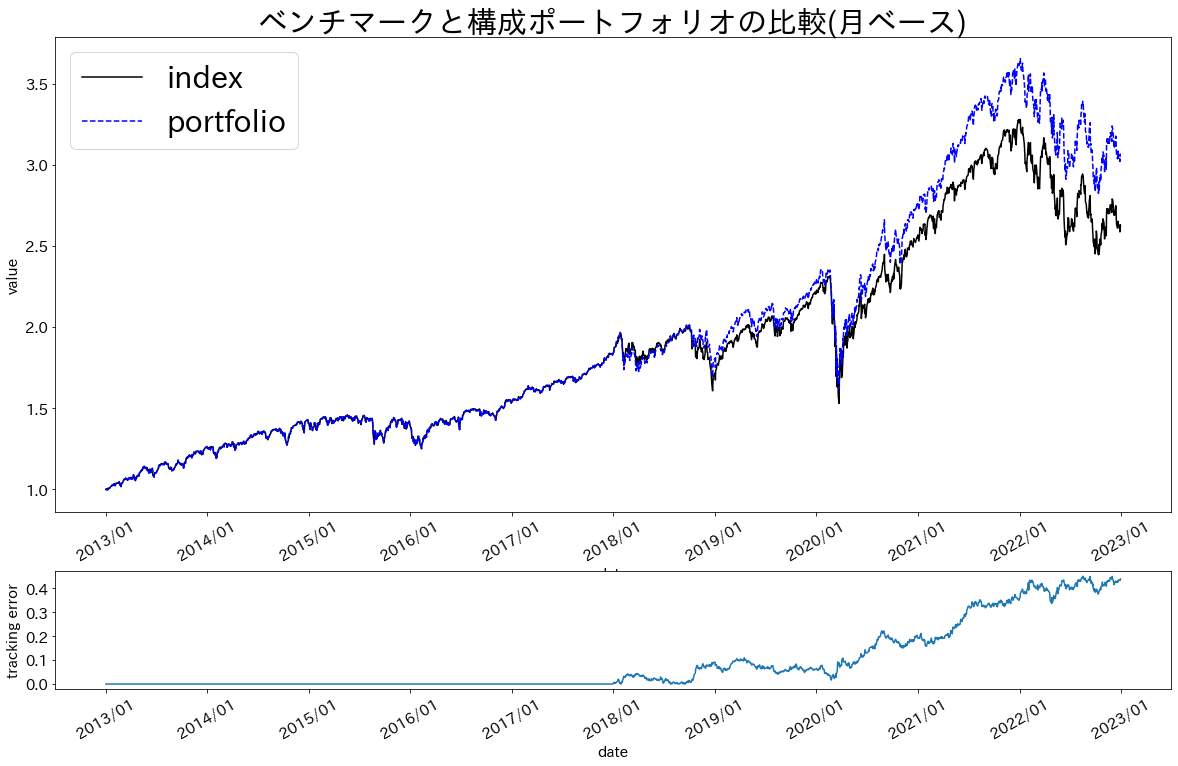

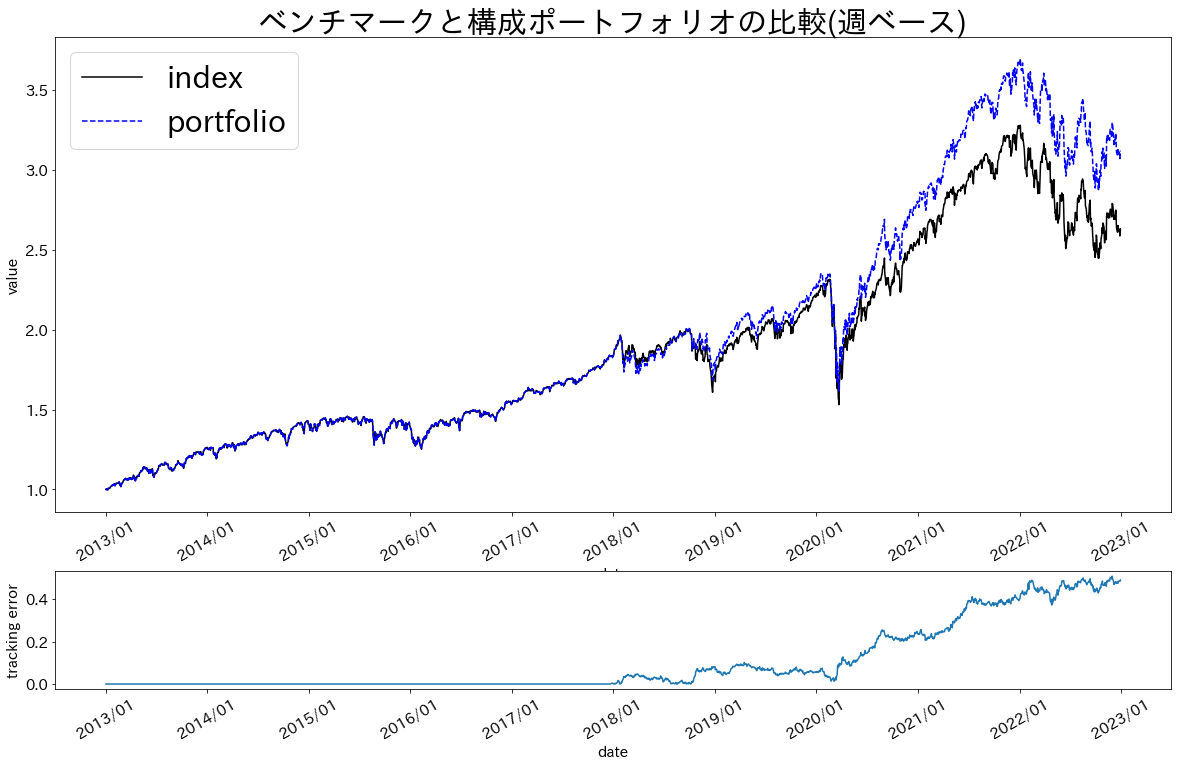

In [1]:
import os as os
import numpy as np
import scipy.stats as st
import cvxpy as cvx
import pandas as pd
import datetime
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
warnings.filterwarnings('ignore')


os.chdir('C:/directindex/ver1')
tickers=pd.read_csv('tickers.csv')
tickers=tickers['ticker'].to_list()


data = pd.read_csv('./data/'+tickers[0]+'.csv')
data = data.drop(['Open', 'High','Low','Close','Adj Close','Volume'], axis=1)


for ticker in tickers:
    d = pd.read_csv('./data/'+ticker+'.csv')
    d = d.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
    d = d.rename(columns={'Close': ticker})
    data = pd.merge(data,d,on='Date')

cal = data[['Date']]
cal['Datetime'] = pd.to_datetime(cal['Date'])
cal['year'] = cal['Datetime'].dt.year
cal['month'] = cal['Datetime'].dt.month
cal['week'] = cal['Datetime'].dt.week


cal['mon'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,3] != cal.iloc[index-1,3]:
        cal.iloc[index,5] = cal.iloc[index-1,5]+1
    else:
        cal.iloc[index,5] = cal.iloc[index-1,5]
        
cal['iweek'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,4] != cal.iloc[index-1,4]:
        cal.iloc[index,6] = cal.iloc[index-1,6]+1
    else:
        cal.iloc[index,6] = cal.iloc[index-1,6]




data = data.set_index('Date')

R = data.pct_change()
R = R.fillna(0)
R = R + 1

#累積リータン
R = R.cumprod()


Benchmark = pd.read_csv('sp500.csv')

Benchmark = Benchmark.set_index('Date')
Benchmark = Benchmark.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)

Benchmark = Benchmark.pct_change()
Benchmark = Benchmark.fillna(0)
Benchmark = Benchmark + 1
Benchmark = Benchmark.cumprod()



#配列T：縦、N：横
T = R.shape[0]
N = R.shape[1]

#------------------------------------------------
#月次シミュレーション
#------------------------------------------------

di = Benchmark.copy() # ポートフォリオの時価総額の推移
dw = pd.DataFrame(index=R.index,columns=R.columns) # 目標配分比率の推移
di_sr = pd.DataFrame(index=R.index,columns=['Close']) # 同一比率リバランスポートフォリオの時価総額の推移
pw = pd.DataFrame(index=R.index,columns=R.columns) # 実績配分比率の推移


#5年分過去リターンをベース、最適ウェイトと求める
mon_window = 60
w_init = np.ones(N)/N
for i in range(120 - mon_window):

    start = i+1
    end = i+mon_window
    # 計算対象の開始終了
    startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].min()
    enddate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].max()


    # 各資産の計算期間分のデータを取得し計算期間初からのリターンを計算
    asset = R[startdate:enddate]
    asset = asset.pct_change()
    asset = asset.fillna(0)
    asset = asset + 1
    asset = asset.cumprod()
    asset = asset.values
    
    # ベンチマークの計算期間分のデータを取得し計算期間初からのリターンを計算
    indx = Benchmark[startdate:enddate]
    indx = indx.pct_change()
    indx = indx.fillna(0)
    indx = indx + 1
    indx = indx.cumprod()
    indx = indx.values
    indx = np.squeeze(indx)

    # 最適化ソルバでウェイトを算出
    weight = cvx.Variable(N,value=w_init)
    obj = cvx.Minimize(cvx.sum_squares(asset@weight - indx))
    mintracerr = cvx.Problem(obj, [cvx.sum(weight) == 1.0,weight >= 0])
    mintracerr.solve(verbose=False)
    w = weight.value

    w[w<0]=0
    w=w/w.sum()
    w_init = w


    # 計算期間の最後のウェイトを運用期間の初期値とする
    calc = asset*np.expand_dims(w, 0)

    al = calc[-1,:]
    w = al/al.sum()

    # 計算したウェイトと運用期間の各資産のリターンから運用期間のポートフォリオの時価評価額の比率を計算
    dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
    dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
    dstartm1 = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()


    #Backtest期間
    rtmp=R[dstartm1:dend]
        
    rtmp = rtmp.pct_change()
    rtmp = rtmp.dropna()
    rtmp = rtmp + 1
    rtmp = rtmp.cumprod()

    d = rtmp.values@w
    d = d*di.at[dstartm1,'Close']

    d = np.expand_dims(d, 1)
    di[dstart:dend]=d
    
#     asset_last = asset[-1,:]
#     w = w*asset_last
#     w=w/w.sum()
#     wt = np.expand_dims(w, 0)
#     dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
#     dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
#     dstartm1 = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()
#     rtmp=R[dstartm1:dend]
#     rtmp = rtmp.pct_change()
#     rtmp = rtmp.dropna()
#     rtmp = rtmp + 1
#     # ポートフォリオ時価総額計算
#     dim1 = di[dstartm1:dstartm1].values
#     w = dim1*w
#     w = np.squeeze(w)
#     d = rtmp.values@w
#     d = np.expand_dims(d, 1)
#     di[dstart:dend]=d


dim1 = di[dstartm1:dstartm1].values
# w = dim1*w

dw = dw.dropna()


import plotly.graph_objects as go
from plotly.subplots import make_subplots
ganpon=100000
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=Benchmark['Close']*ganpon,
                         mode='lines',
                         name='SP500',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=di.index,
                         y=di['Close']*ganpon,
                         mode='lines',
                         name='Portfolio',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=((Benchmark['Close']*ganpon-di['Close']*ganpon)**2)**0.5,
                         mode='lines',
                         name='Tracking error',
                        ), row=2, col=1
              )


Benchmark.to_csv('b2.csv')
di.to_csv('d2.csv')

import japanize_matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import dates as mdates

heights = [4, 1]
fig = plt.figure(figsize=(20, 12))
spec = fig.add_gridspec(ncols=1, nrows=2,  height_ratios=heights)
ax = fig.add_subplot(spec[0, 0])

ax.plot(pd.to_datetime(Benchmark.index),Benchmark['Close'],c='k')
ax.plot(pd.to_datetime(di.index),di['Close'],c='b',linestyle="--")


ax.legend(labels=['index','portfolio'],fontsize=30)
ax.set_xlabel('date', size=15)
ax.set_ylabel('value', size=15)
ax.set_title('ベンチマークと構成ポートフォリオの比較(月ベース)', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

ax = fig.add_subplot(spec[1, 0])
ax.plot(pd.to_datetime(Benchmark.index),((Benchmark['Close']-di['Close'])**2)**0.5)
ax.set_xlabel('date', size=15)
ax.set_ylabel('tracking error', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))


#------------------------------------------------
#週次シミュレーション
#------------------------------------------------

di = Benchmark.copy() # ポートフォリオの時価総額の推移
dw = pd.DataFrame(index=R.index,columns=R.columns) # 目標配分比率の推移
di_sr = pd.DataFrame(index=R.index,columns=['Close']) # 同一比率リバランスポートフォリオの時価総額の推移
pw = pd.DataFrame(index=R.index,columns=R.columns) # 実績配分比率の推移


#5年分過去リターンをベース、最適ウェイトと求める
week_window = 260
w_init = np.ones(N)/N
for i in range(522 - week_window):

    start = i+1
    end = i+week_window
    # 計算対象の開始終了
    startdate = cal.query('iweek >= '+str(start)+' and iweek <= '+str(end))['Date'].min()
    enddate = cal.query('iweek >= '+str(start)+' and iweek <= '+str(end))['Date'].max()
    


    # 各資産の計算期間分のデータを取得し計算期間初からのリターンを計算
    asset = R[startdate:enddate]
    asset = asset.pct_change()
    asset = asset.fillna(0)
    asset = asset + 1
    asset = asset.cumprod()
    asset = asset.values
    
    # ベンチマークの計算期間分のデータを取得し計算期間初からのリターンを計算
    indx = Benchmark[startdate:enddate]
    indx = indx.pct_change()
    indx = indx.fillna(0)
    indx = indx + 1
    indx = indx.cumprod()
    indx = indx.values
    indx = np.squeeze(indx)

    # 最適化ソルバでウェイトを算出
    weight = cvx.Variable(N,value=w_init)
    obj = cvx.Minimize(cvx.sum_squares(asset@weight - indx))
    mintracerr = cvx.Problem(obj, [cvx.sum(weight) == 1.0,weight >= 0])
    mintracerr.solve(verbose=False)
    w = weight.value

    w[w<0]=0
    w=w/w.sum()
    w_init = w


    # 計算期間の最後のウェイトを運用期間の初期値とする
    calc = asset*np.expand_dims(w, 0)

    al = calc[-1,:]
    w = al/al.sum()

    # 計算したウェイトと運用期間の各資産のリターンから運用期間のポートフォリオの時価評価額の比率を計算
    dstart = cal.query('iweek >= '+str(end+1)+' and iweek <= '+str(end+1))['Date'].min()
    dend = cal.query('iweek >= '+str(end+1)+' and iweek <= '+str(end+1))['Date'].max()
    dstartm1 = cal.query('iweek >= '+str(end)+' and iweek <= '+str(end))['Date'].max()

    #Backtest期間
    rtmp=R[dstartm1:dend]
        
    rtmp = rtmp.pct_change()
    rtmp = rtmp.dropna()
    rtmp = rtmp + 1
    rtmp = rtmp.cumprod()

    d = rtmp.values@w
    d = d*di.at[dstartm1,'Close']

    d = np.expand_dims(d, 1)
    di[dstart:dend]=d
    
# #     asset_last = asset[-1,:]
# #     w = w*asset_last
# #     w=w/w.sum()
# #     wt = np.expand_dims(w, 0)
# #     dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
# #     dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
# #     dstartm1 = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()
# #     rtmp=R[dstartm1:dend]
# #     rtmp = rtmp.pct_change()
# #     rtmp = rtmp.dropna()
# #     rtmp = rtmp + 1
# #     # ポートフォリオ時価総額計算
# #     dim1 = di[dstartm1:dstartm1].values
# #     w = dim1*w
# #     w = np.squeeze(w)
# #     d = rtmp.values@w
# #     d = np.expand_dims(d, 1)
# #     di[dstart:dend]=d


dim1 = di[dstartm1:dstartm1].values
# w = dim1*w

dw = dw.dropna()


import plotly.graph_objects as go
from plotly.subplots import make_subplots
ganpon=100000
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=Benchmark['Close']*ganpon,
                         mode='lines',
                         name='SP500',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=di.index,
                         y=di['Close']*ganpon,
                         mode='lines',
                         name='Portfolio',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=((Benchmark['Close']*ganpon-di['Close']*ganpon)**2)**0.5,
                         mode='lines',
                         name='Tracking error',
                        ), row=2, col=1
              )


Benchmark.to_csv('b3.csv')
di.to_csv('d3.csv')

import japanize_matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import dates as mdates

heights = [4, 1]
fig = plt.figure(figsize=(20, 12))
spec = fig.add_gridspec(ncols=1, nrows=2,  height_ratios=heights)
ax = fig.add_subplot(spec[0, 0])

ax.plot(pd.to_datetime(Benchmark.index),Benchmark['Close'],c='k')
ax.plot(pd.to_datetime(di.index),di['Close'],c='b',linestyle="--")


ax.legend(labels=['index','portfolio'],fontsize=30)
ax.set_xlabel('date', size=15)
ax.set_ylabel('value', size=15)
ax.set_title('ベンチマークと構成ポートフォリオの比較(週ベース)', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

ax = fig.add_subplot(spec[1, 0])
ax.plot(pd.to_datetime(Benchmark.index),((Benchmark['Close']-di['Close'])**2)**0.5)
ax.set_xlabel('date', size=15)
ax.set_ylabel('tracking error', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))